# Higgs Classification

By Alexander Chkodrov  
November 11th, 2019

Perform an inclusive search for the standard model Higgs boson in pp collisions at √ s = 13 TeV at the LHC using simulated data. Use a set of training datasets to optimize event selections in order to enhance the discovery sensitivity. The optimal event selections will be applied to a selected pseudo-experiment data.

In [1]:
import pickle
import math
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt

#import scikit

In [2]:
infile_qcd = open("qcd_100000_pt_1000_1200.pkl", 'rb')
qcd_dict = pickle.load(infile_qcd)

infile_higgs = open("higgs_100000_pt_1000_1200.pkl", 'rb')
higgs_dict = pickle.load(infile_higgs)

In [3]:
qcd_dict.describe()

,pt,eta,phi,mass,ee2,ee3,d2,angularity,t1,t2,t3,t21,t32,KtDeltaR
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1099.069078,0.000059,-0.004369,177.273131,0.060813,1.590390e-03,8.524137,0.004655,0.882786,0.538226,0.427151,0.609811,0.787470,0.290562
std,52.703594,0.824677,1.813312,99.972322,0.056125,3.717299e-03,8.752416,0.004442,0.171584,0.207649,0.186342,0.210203,0.122872,0.260068
min,1000.000072,-2.253943,-3.141548,11.984485,0.000710,1.819649e-07,0.086661,0.000001,0.478295,0.015832,0.012631,0.011572,0.047420,0.003521
25%,1055.360052,-0.621201,-1.579458,108.600737,0.021942,1.177585e-04,2.519231,0.001443,0.776871,0.382444,0.276735,0.462381,0.727120,0.072682
50%,1096.388294,0.001059,-0.009028,148.278900,0.041349,3.785610e-04,5.305667,0.003423,0.867831,0.548069,0.424227,0.637342,0.812622,0.207665
75%,1141.960746,0.622000,1.571494,217.478737,0.079923,1.344164e-03,11.599896,0.006412,0.955881,0.702849,0.573291,0.776890,0.876461,0.450668
max,1199.997316,2.300489,3.141578,791.955000,0.470946,9.376276e-02,507.574110,0.043964,3.994753,2.572832,1.079607,0.988677,0.991950,1.268862


In [4]:
higgs_dict.describe()

,pt,eta,phi,mass,ee2,ee3,d2,angularity,t1,t2,t3,t21,t32,KtDeltaR
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1102.501996,-0.000017,-0.002699,126.663832,0.052299,0.000211,2.135631,0.001129,0.884533,0.288156,0.208147,0.334023,0.756502,0.260286
std,45.837988,0.549608,1.817242,8.407990,0.011856,0.000092,2.877196,0.001404,0.218984,0.161642,0.109353,0.176161,0.128856,0.100810
min,1000.012858,-1.954299,-3.141460,22.774890,0.004463,0.000002,0.309460,0.000008,0.543191,0.059126,0.044392,0.037226,0.134330,0.005540
25%,1071.301774,-0.386609,-1.577841,125.518250,0.046231,0.000142,0.891169,0.000333,0.734242,0.163427,0.131810,0.192856,0.686449,0.213529
50%,1105.070241,-0.003436,-0.004695,126.838370,0.055835,0.000191,1.269670,0.000644,0.831604,0.240890,0.178368,0.295150,0.785742,0.235491
75%,1136.769935,0.385129,1.577628,129.145697,0.060689,0.000266,2.093390,0.001313,0.968658,0.375077,0.252761,0.446858,0.852609,0.285297
max,1195.808499,1.916136,3.141587,154.613675,0.076202,0.000673,54.951194,0.033048,3.756501,1.877362,0.960652,0.978955,0.987376,0.950338


In this analysis the goal is to confirm the existance of the Higgs boson with maximum confidence. Direct observation of the Higgs is obscured by QCD background contamination, so instead observation of the parameters/features influenced by the presence of the Higgs boson will confirm discovery.

According to the Standard Model, the Higgs Boson is the quantum particle that gives particles their masses. We will use the mass of a jet as a feature to descriminate between the Higgs particles and QCD background noise. The other features we will examine later.

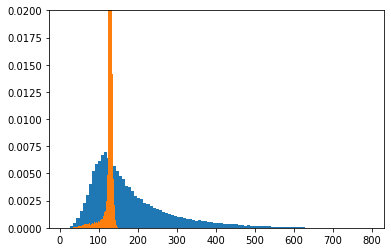

In [5]:
hist_qcd = plt.hist(qcd_dict.get('mass'), density=True, bins=100)
hist_higgs = plt.hist(higgs_dict.get('mass'), density=True, bins=100)
plt.ylim(0,0.02)
plt.show()

This is a histogram of the QCD jet mass (blue) and the Higgs jet mass (orange). The histograms are by visual inspection very different, and so would make a good candidate for a descriminatory feature.

In [6]:
tot = higgs_dict.mass + qcd_dict.mass

In [7]:
x = np.linspace(min(tot), max(tot), len(tot))
significance = stats.norm.ppf(stats.norm.cdf(tot, loc=2050, scale=math.sqrt(2050)))
#plt.scatter(x, significance, marker=".", linewidth=.00000000001)
print('S_avg: ', significance.mean())
#plt.show()

S_avg:  -inf


Ignoring the above histograms, lets assume the mass distributions for the QCD background and the Higgs signal are both Poisson with expected yields $N_{QCD} = 2000$ and $N_{Higgs} = 50$. Each distribution has a $\lambda = N$, where N is the given expected yield of the data set. For a poisson distribution with large $\lambda$, it can be approximated by a Gaussian distributed variable with mean $\lambda$ and standard deviation $\sqrt\lambda$.

Let $X$ be the sum of the two distributions with average $\lambda_{tot} = \lambda_{QCD}+\lambda_{Higgs}$, therefore also poisson distributed. It can be approximated by a Gaussian distribution with average $\lambda_{QCD}+\lambda_{Higgs}$ and standard deviation $\sqrt{\lambda_{QCD}+\lambda_{Higgs}}$. Let $S$ be the significance. Using the Gaussian quantile function $\Phi^{-1}$, the inverse of the cumulative distribution function, we find an approximation for the expected significance 
$$S = \Phi^{-1}(1-p)$$
The p-value of the background only given an event $x$ is
$$p = 1 - \Phi({\frac{x-\mu}{\sigma}})$$
Where $\mu = \lambda_{QCD}$ and $\sigma = \sqrt{\lambda_{QCD}}$,
$$p = 1 - \Phi({\frac{x-\lambda_{QCD}}{\sqrt{\lambda_{QCD}}}})$$
Setting up for our equation for significance,
$$1-p = \Phi({\frac{x-\lambda_{QCD}}{\sqrt{\lambda_{QCD}}}})$$
$$\Phi^{-1}(1-p) = \frac{x-\lambda_{QCD}}{\sqrt{\lambda_{QCD}}}$$
Finally our value for significance,
$$S_x = \frac{x-\lambda_{QCD}}{\sqrt{\lambda_{QCD}}}$$
The average of X is $\lambda_{QCD}+\lambda_{Higgs}$
$$S_{avg} = \frac{\lambda_{Higgs}}{\sqrt{\lambda_{QCD}}}$$

By this formula, the average significance of the distribution X (the sum of the Higgs and QCD distributions) is the same as $\frac{N_{QCD}}{\sqrt{N_{QCD}}}$. Of course, this all depends on the distribution of Higgs mass and QCD mass both being Poisson distributed.

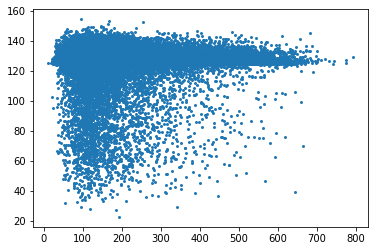

In [8]:
x = np.linspace(min(qcd_dict.mass), max(qcd_dict.mass), len(qcd_dict.mass))
plt.scatter(qcd_dict.mass, higgs_dict.mass, marker='.', linewidth=0.0001)

There is visible seperation between the Higgs masses and QCD masses in the scatter plot above. Using a random grid search where very point in the Higgs data set becomes the corner of a cut would be too computationally expensive but would give the best results.

In [9]:
best_sig_gt = 0
best_sig_lt = 0
best_cut_gt = 0
size = len(qcd_dict.mass)
for m in higgs_dict.mass:
    higgs_gt_m = len(higgs_dict.mass[higgs_dict.mass>m])
    qcd_gt_m = len(qcd_dict.mass[qcd_dict.mass>m])
    higgs_lt_m = size - higgs_gt_m
    qcd_lt_m = size-qcd_gt_m
    #Cut all less than m; find significance
    N_higgs = 50*higgs_gt_m/size
    N_qcd = 2000*qcd_gt_m/size
    expected_sig = N_higgs / math.sqrt(N_qcd)
    if(expected_sig > best_sig_gt):
        best_sig_gt = expected_sig
        best_cut_gt = m
    #Cut all greater than m; find significance
    N_higgs = 50*higgs_lt_m/size
    N_qcd = 2000*qcd_lt_m/size
    expected_sig = N_higgs / math.sqrt(N_qcd)
    if(expected_sig > best_sig_lt):
        best_sig_lt = expected_sig
        best_cut_lt = m
        
print(f'Best mass cut range: ({best_cut_gt:.2f}, {best_cut_lt:.2f})')

Best mass cut range: (122.45, 137.22)


In [10]:
N_higgs = 50*len(higgs_dict.mass[higgs_dict.mass.between(best_cut_gt,best_cut_lt)])/size
N_qcd = 2000*len(qcd_dict.mass[qcd_dict.mass.between(best_cut_gt,best_cut_lt)])/size
expected_sig = N_higgs / math.sqrt(N_qcd)
print(f'Expected significance in best mass cut range: {expected_sig:.2f}')

Expected significance in best mass cut range: 3.41


Using a random grid search starting from either side of the mass distribution, we find cutting all mass data outside the range 122.5 to 137.2 maximizes expected significance using the formula $S = \frac{N_{Higgs}}{\sqrt{N_{QCD}}}$. In other words, the range contains the maximum signal-to-noise ratio in this dataset. The expected significance of the Higgs observation in the range coming from the distribution X, the sum of signal and background distributions, would be around 3.4 sigma.

Some stacked histograms for the rest of the features are below, with the Higgs data set in orange and the QCD background in blue. This is without any event selection or cuts.

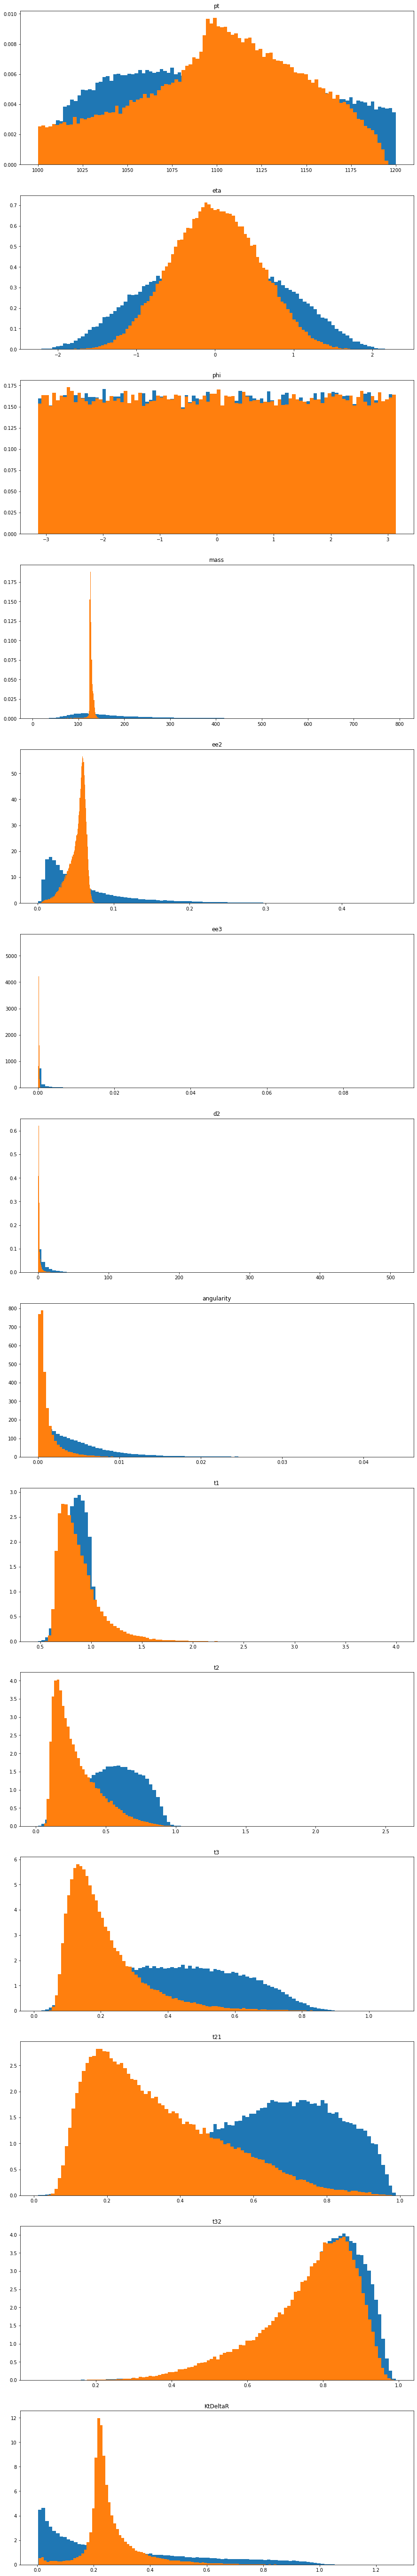

In [11]:
fig, ax_arr = plt.subplots(len(qcd_dict.keys()),1, figsize=(15,100))
index = 0
for key in qcd_dict.keys():
    ax_arr[index].hist(qcd_dict.get(key), bins=100, density=True)
    ax_arr[index].title.set_text(key)
    ax_arr[index].hist(higgs_dict.get(key), bins=100, density=True)
    ax_arr[index].title.set_text(key)
    index += 1

Now, with our optimal mass cut reducing the data set and plotted again,

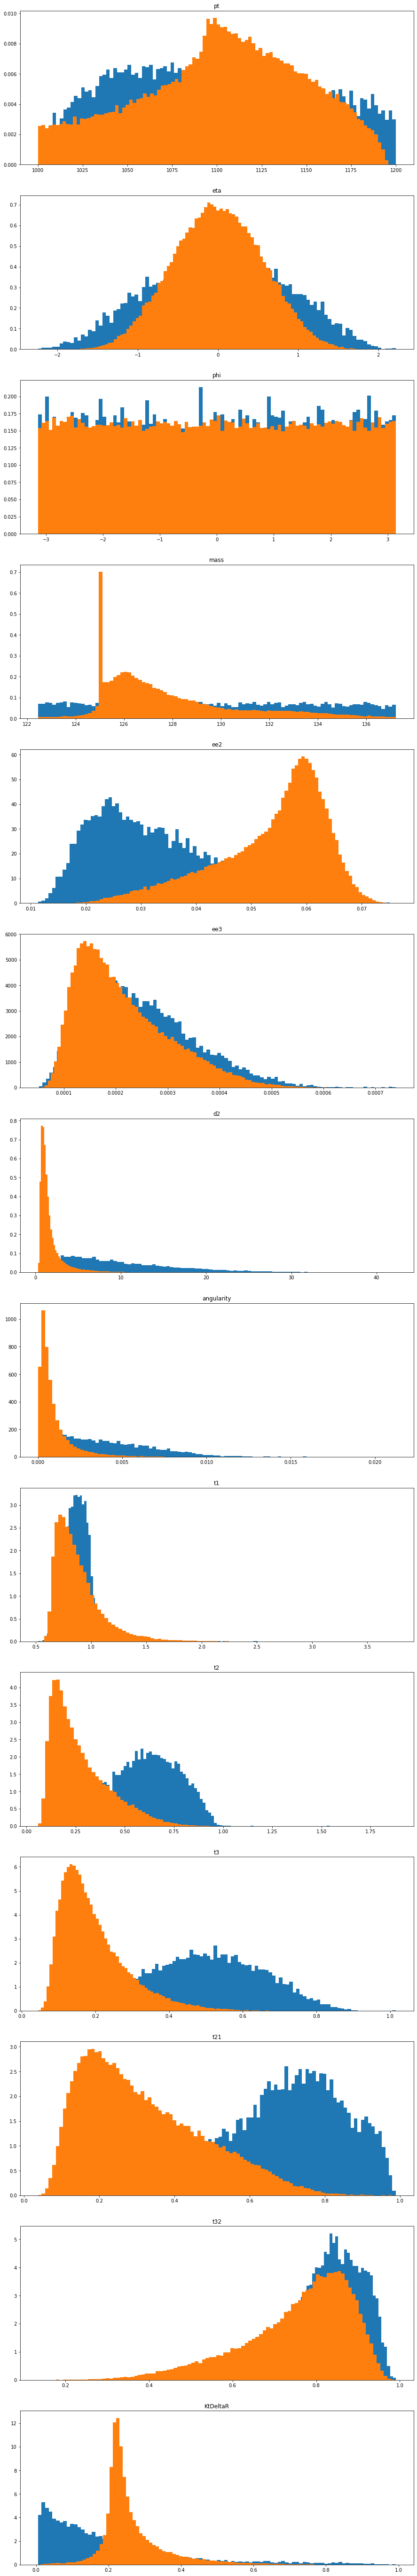

In [12]:
higgs_cut = higgs_dict[higgs_dict.mass.between(best_cut_gt,best_cut_lt)]
qcd_cut = qcd_dict[qcd_dict.mass.between(best_cut_gt,best_cut_lt)]
fig, ax_arr = plt.subplots(len(qcd_cut.keys()),1, figsize=(15,100))
index = 0
for key in qcd_dict.keys():
    ax_arr[index].hist(qcd_cut.get(key), bins=100, density=True)
    ax_arr[index].title.set_text(key)
    ax_arr[index].hist(higgs_cut.get(key), bins=100, density=True)
    ax_arr[index].title.set_text(key)
    index += 1

By visual inspection, the features ee2 and d2 and ktDeltaR provide good descriminatory power.

In [13]:
corr_table = qcd_dict.corr()
a = (corr_table-np.eye(len(corr_table))).max()
b = (corr_table-np.eye(len(corr_table))).idxmax()
pd.DataFrame([a,b]).T

,0,1
pt,0.0954613,mass
eta,0.00178366,phi
phi,0.00284771,t32
mass,0.959965,ee2
ee2,0.959965,mass
ee3,0.844699,ee2
d2,0.622112,t3
angularity,0.529638,mass
t1,0.326725,t2
t2,0.93664,t3


The feature ee2 and mass are highly correlated, although d2 and KtDeltaR are more independant.

best_sig_gt = 0
best_sig_lt = 0
best_cut_gt = 0
best_cut_lt = 0
size = len(qcd_dict.d2)
for d in higgs_cut.d2:
    higgs_gt_d = len(higgs_dict.d2[higgs_dict.d2>d])
    qcd_gt_d = len(qcd_dict.d2[qcd_dict.d2>d])
    higgs_lt_d = size - higgs_gt_d
    qcd_lt_d = size-qcd_gt_d
    #Cut all less than d; find significance
    N_higgs = 50*higgs_gt_d/size
    N_qcd = 2000*qcd_gt_d/size
    expected_sig = N_higgs / math.sqrt(N_qcd)
    if(expected_sig > best_sig_gt):
        best_sig_gt = expected_sig
        best_cut_gt = d
    #Cut all greater than d; find significance
    N_higgs = 50*higgs_lt_d/size
    N_qcd = 2000*qcd_lt_d/size
    expected_sig = N_higgs / math.sqrt(N_qcd)
    if(expected_sig > best_sig_lt):
        best_sig_lt = expected_sig
        best_cut_lt = d
        
print(f'Best mass cut range: ({best_cut_gt:.2f}, {best_cut_lt:.2f})')

higgs_mask = higgs_dict.d2.between(best_cut_gt,best_cut_lt) & higgs_dict.mass.between(122.45, 137.22)
qcd_mask = qcd_dict.d2.between(best_cut_gt,best_cut_lt) & qcd_dict.mass.between(122.45, 137.22)
N_higgs = 50*len(higgs_dict.mass[higgs_mask])/size
N_qcd = 2000*len(qcd_dict.mass[qcd_mask])/size
expected_sig = N_higgs / math.sqrt(N_qcd)
print(f'Expected significance in best cut range: {expected_sig:.2f}')
print(f'N_higgs: {N_higgs:.0f}, N_QCD: {N_qcd:.0f}')

In the above example, the optimal cuts for d2 were found seperately from the optimal cuts for mass, and then when using both for event selection we end with an expected significance of 26 sigma, however it analyzes a very small portion of the data (29 events out of 100k events).

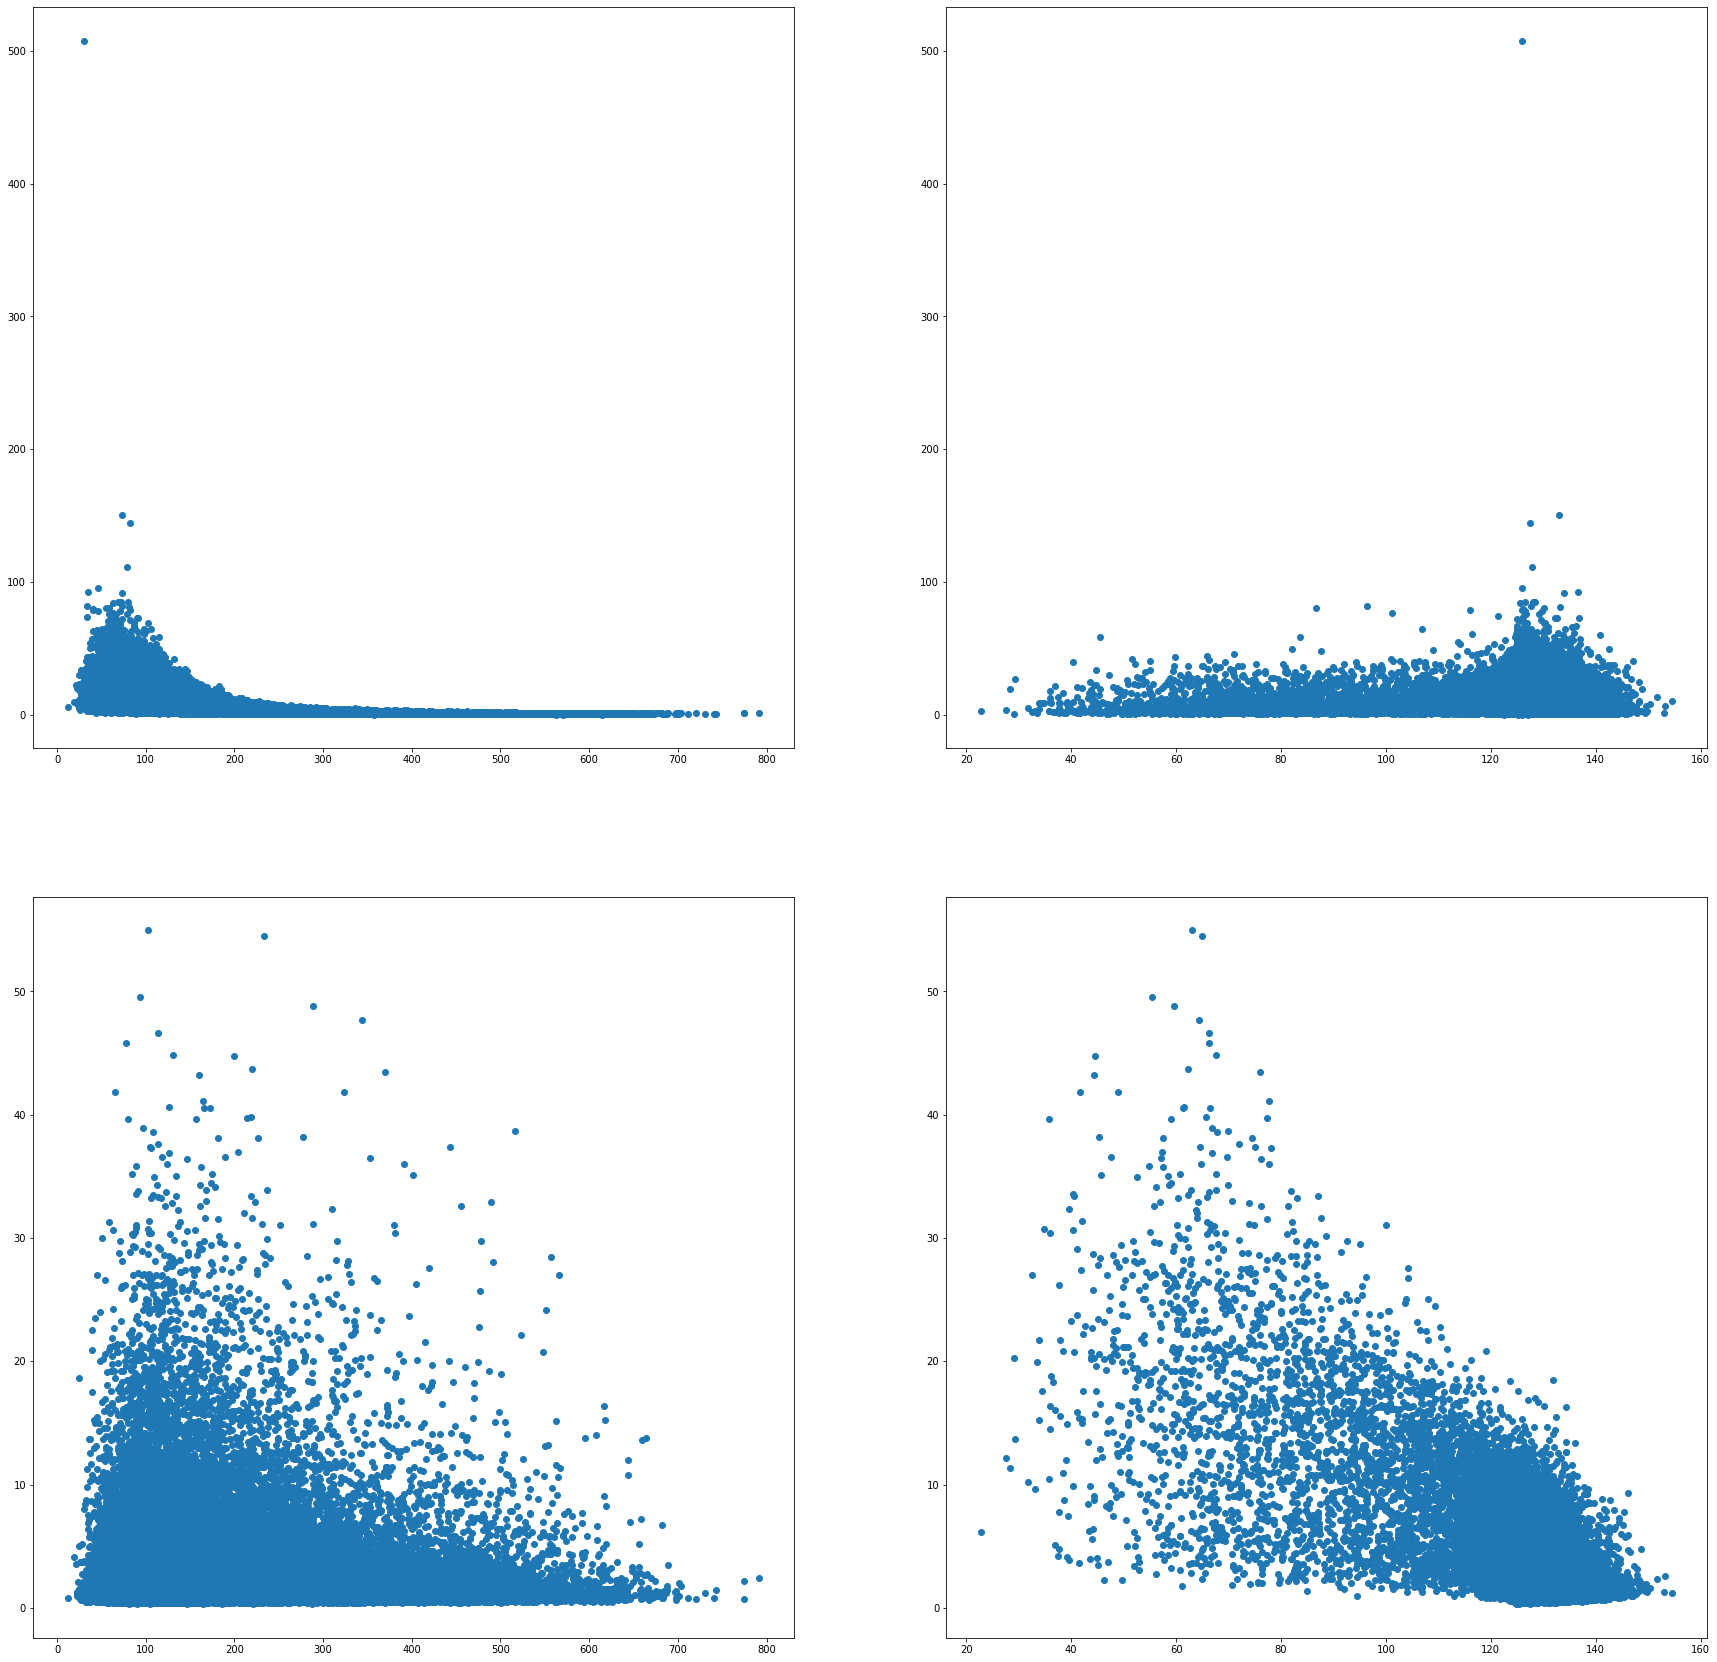

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(30,30))
ax[0][0].scatter(qcd_dict.mass, qcd_dict.d2)
ax[1][0].scatter(qcd_dict.mass, higgs_dict.d2)
ax[0][1].scatter(higgs_dict.mass, qcd_dict.d2)
ax[1][1].scatter(higgs_dict.mass, higgs_dict.d2)
plt.show()

In [17]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn import svm

#iris = load_iris()
#X, y = iris.data, iris.target

X = higgs_dict.append(qcd_dict)
y = np.append(np.ones((len(higgs_dict),1), dtype=int),np.zeros((len(qcd_dict),1),dtype=int))


array([1, 1, 1, ..., 0, 0, 0])

In [19]:
clf = svm.SVC(kernel='poly', degree=3, gamma='scale')
clf.fit(X,y)
#plt.clf()
#plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
#            facecolors='none', zorder=10, edgecolors='k')
#plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired,
#            edgecolors='k')
X.shape

(200000, 14)

TypeError: '(slice(None, None, None), 0)' is an invalid key

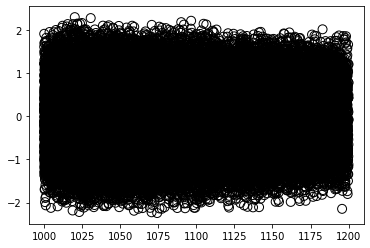

In [22]:
plt.clf()
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
            facecolors='none', zorder=10, edgecolors='k')
plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired,
            edgecolors='k')
X.shape

In [24]:
clf.score(X,y)

0.889165